In [11]:
import strax

In [12]:
####### setting of the current analysis,add plugins and storage sites
my_storage_site = strax.DataDirectory('/data1')
st   = strax.Context(
                register=[
                strax.CAENRecords,
                strax.PulseProcessing,
                strax.Peaklets],
                storage=[my_storage_site]
                    )

In [13]:
### find the sources that are ready for analysis
dsets = st.select_runs(available = 'peaklets') ## available: means which type of the data that are available
print(dsets)


Checking data availability:   0%|          | 0/1 [00:00<?, ?it/s]

Empty DataFrame
Columns: [name, number, mode, source, tags, peaklets_available]
Index: []


We can see that dsets is pandas DataFrame, and the name and number indicates which run the data belongs to. For example, number 3070 corresponds to the run3 segmentation70 data. 

In [14]:
### lets get all the run3 data
run_ids  = [i for i in dsets['name'] if i[4]=='3']
peaklets = st.get_array(run_id=run_ids,targets='peaklets') 
print(len(peaklets))

IndexError: tuple index out of range

New we have loaded all the run3 peaklets,totally 6898324 peaklets. Lets take a look at some of the them

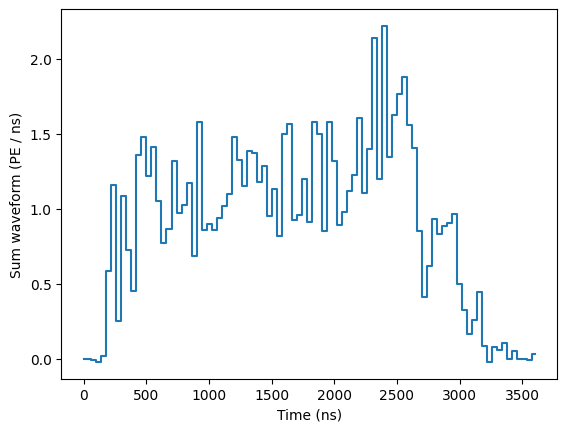

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_peaklet(p, t0=None, **kwargs):
    n = p['length']
    if t0 is None:
        t0 = p['time']
    plt.plot((p['time'] - t0) + np.arange(n) * p['dt'], 
             p['data'][:n] / p['dt'], 
             drawstyle='steps-mid',
             **kwargs)
    plt.xlabel("Time (ns)")
    plt.ylabel("Sum waveform (PE / ns)")

plot_peaklet(peaklets[2])
plt.show()

It seems to be a S2 peak. But note that the peaklets are not classified.All the peaks' type are set to be 0

In [ ]:
print(peaklets['type'])

[0 0 0 ... 0 0 0]


In [ ]:
### You can get the type of these peaklets by using the default peaklet classification plugin
st.register(strax.PeakletClassification) ## add default peaklet classificatoin plugin
peaklets_classification = st.get_array(run_id=run_ids,targets='peaklet_classification') ## apply this plugin

/home/user/data_process/strax/utils.py:494: UserWarning: You are asking for more than 70 runs at a time with add_run_id_field=True. Changing run_id data_type from string to bytes would reduce memory consumption. Do so with passing "run_id_as_bytes=True" . When you do, please note that "run_id" != b"run_id"! You can convert a byte string back to a normal string via b"byte_string".decode("utf-8"). 
  warn('You are asking for more than 70 runs at a time with add_run_id_field=True. '


Loading 91 runs:   0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
print(peaklets_classification['type'])

[2 2 2 ... 2 2 1]


You can also write your own classification plugin. Just to inherit the strax.plugin class

In [ ]:
#### show case of a strax plugin
class AdvancedExpertClassification(strax.Plugin):
    """Everything is an S1!"""
    
    # Name of the data type this plugin provides
    provides = 'peaklet_classification'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('peaklets',)
    
    # Numpy datatype of the output 
    dtype = strax.PeakletClassification.dtype
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.2'

    def compute(self, peaklets):
        # Your code here.
        # This function will be called several times with 
        # 'peaks' a numpy array of the datatype 'peaks'.
        # Each time you'll see a small part of the run.
        
        # You have to return a numpy array of the dtype you declared above
        result = np.zeros(len(peaklets), self.dtype)
        
        # Copy the basic time fields over from peaklets
        for (_, field), _ in strax.time_dt_fields:
            result[field] = peaklets[field]
            
        # Store the classification results
        # You might want to do real work here
        result['type'] = 1
        
        return result
        
        # Instead of an array, you are also allowed to return a dictionary 
        # we can transform into an array.
        # That is, (dict keys -> field names, values -> field values)

In [ ]:
st2 = st.new_context(storage=[strax.DataDirectory('/home/user/data_process/test')]) ## set a new context,change storage site
st2.register(AdvancedExpertClassification)  ## add this plugin
ptype = st2.get_array(run_id=run_ids,targets='peaklet_classification') ## apply this plugin
print(ptype['type'])

/home/user/data_process/strax/utils.py:494: UserWarning: You are asking for more than 70 runs at a time with add_run_id_field=True. Changing run_id data_type from string to bytes would reduce memory consumption. Do so with passing "run_id_as_bytes=True" . When you do, please note that "run_id" != b"run_id"! You can convert a byte string back to a normal string via b"byte_string".decode("utf-8"). 
  warn('You are asking for more than 70 runs at a time with add_run_id_field=True. '


Loading 91 runs:   0%|          | 0/91 [00:00<?, ?it/s]

[1 1 1 ... 1 1 1]
